# ITP117 Lab 9: Further CNN

If you have any question relate to this lab session, please email to Yunpyo An (anyunpyo@unist.ac.kr)

## Exercise 5: ResNet with subclassing & sequential API

In [1]:
# Check your device for learning
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import os

from tensorflow import keras
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical # return a binary matrix representation of the input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
class ResidualUnit(keras.layers.Layer): # ResNet-34
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation) # relu activation inthis example
    self.main_layers = [
      keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
      keras.layers.BatchNormalization(),
      self.activation,
      keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
      keras.layers.BatchNormalization()]
    self.skip_layers = [] # to make short cut
    if strides > 1:
      self.skip_layers = [
        keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
      keras.layers.BatchNormalization()]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
      skip_Z = inputs
      for layer in self.skip_layers: # adding short-cut
        skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[28, 28, 1], padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 0
filter_list = [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]
for filters in filter_list:
  # [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides)) # Adding Residual model
  prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        3136      
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 residual_unit_1 (ResidualU  (None, 4, 4, 64)          78592     
 nit)                                                            
                                                      

## Exercise 6: Training ResNet for fashion MNIST

In [ ]:
# load fashion MNIST data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
# data normalization
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid,y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 130s 52ms/step - loss: 0.5721 - accuracy: 0.8085 - val_loss: 0.3790 - val_accuracy: 0.8676
Epoch 2/10
1719/1719 [==============================] - 85s 49ms/step - loss: 0.4018 - accuracy: 0.8615 - val_loss: 0.3333 - val_accuracy: 0.8824
Epoch 3/10
1719/1719 [==============================] - 86s 50ms/step - loss: 0.3566 - accuracy: 0.8767 - val_loss: 0.4478 - val_accuracy: 0.8488
Epoch 4/10
1719/1719 [==============================] - 84s 49ms/step - loss: 0.3400 - accuracy: 0.8820 - val_loss: 0.3201 - val_accuracy: 0.8816
Epoch 5/10
1719/1719 [==============================] - 84s 49ms/step - loss: 0.3070 - accuracy: 0.8911 - val_loss: 0.2720 - val_accuracy: 0.8988
Epoch 6/10
1719/1719 [==============================] - 84s 49ms/step - loss: 0.2710 - accuracy: 0.9025 - val_loss: 0.3017 - val_accuracy: 0.8962
Epoch 7/10
1719/1719 [==============================] - 85s 50ms/step - loss: 0.2449 - accuracy: 0.9113 - val_loss: 0.3298 

## Exercise 7: Training ResNet for CIFAR10

In [ ]:
def visualize_data(images, categories, class_names):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    for i in range(3 * 7):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        class_index = categories[i].argmax()
        plt.xlabel(class_names[class_index])
    plt.show()

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

170498071/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3) (50000, 10)


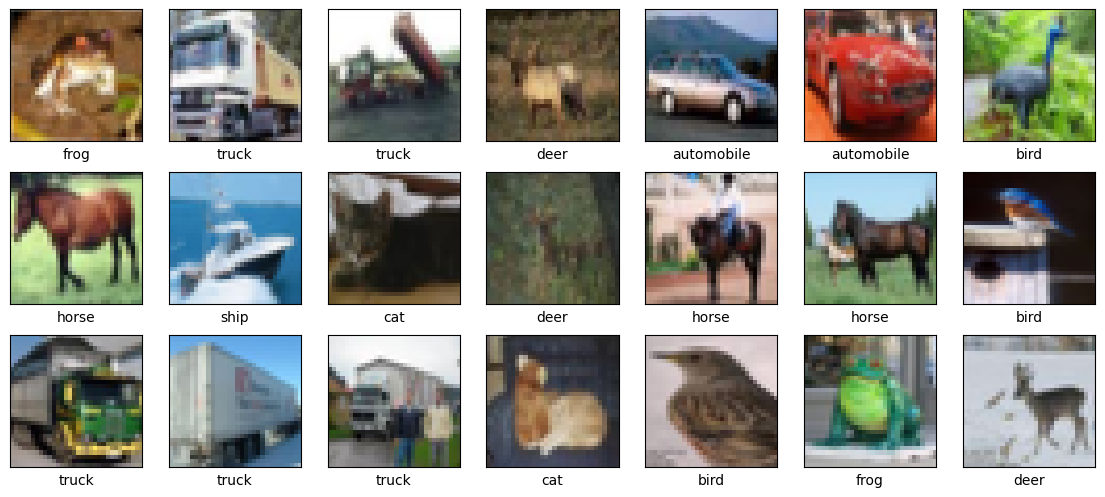

In [ ]:
print(x_train.shape, y_train.shape)
visualize_data(x_train, y_train, class_names)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[32, 32, 3], padding="same", use_bias=False))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 0
filter_list = [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]
for filters in filter_list:
  # [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 16, 16, 64)        9408      
                                                                 
 batch_normalization_39 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_3 (Activation)   (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 residual_unit_18 (Residual  (None, 4, 4, 64)          78592     
 Unit)                                                           
                                                      

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test))
score = model.evaluate(x_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 106s 53ms/step - loss: 1.6528 - accuracy: 0.4189 - val_loss: 1.4896 - val_accuracy: 0.4664
Epoch 2/10
1563/1563 [==============================] - 81s 52ms/step - loss: 1.2951 - accuracy: 0.5443 - val_loss: 1.2337 - val_accuracy: 0.5626
Epoch 3/10
1563/1563 [==============================] - 82s 52ms/step - loss: 1.1416 - accuracy: 0.6035 - val_loss: 1.1424 - val_accuracy: 0.5939
Epoch 4/10
1563/1563 [==============================] - 82s 52ms/step - loss: 1.0315 - accuracy: 0.6442 - val_loss: 1.1887 - val_accuracy: 0.5888
Epoch 5/10
1563/1563 [==============================] - 80s 51ms/step - loss: 0.9416 - accuracy: 0.6763 - val_loss: 1.0349 - val_accuracy: 0.6381
Epoch 6/10
1563/1563 [==============================] - 82s 53ms/step - loss: 0.8938 - accuracy: 0.6940 - val_loss: 1.1831 - val_accuracy: 0.5929
Epoch 7/10
1563/1563 [==============================] - 79s 50ms/step - loss: 0.8362 - accuracy: 0.7168 - val_loss: 1.6314 

## Exercise 8: CIFAR10 with data augmentation

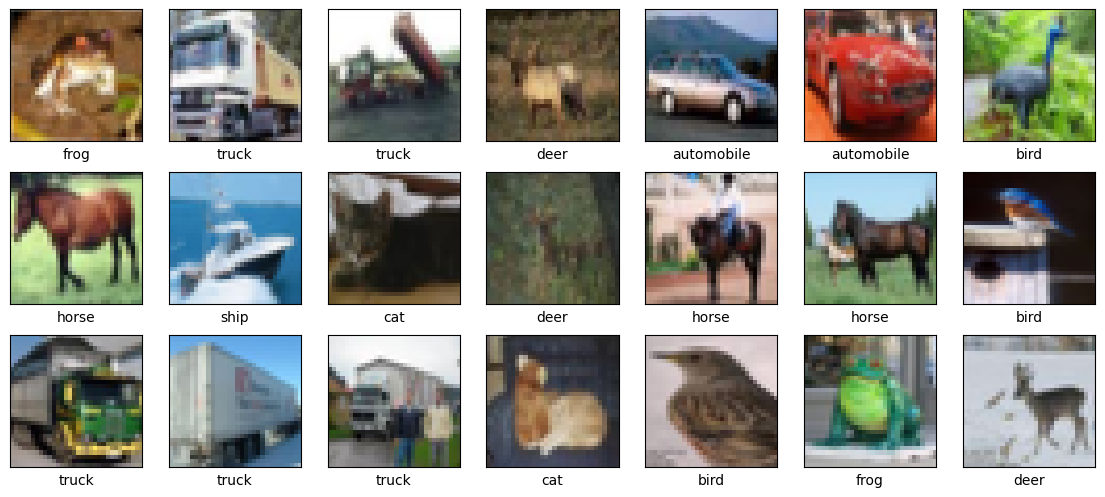

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

visualize_data(x_train, y_train, class_names)

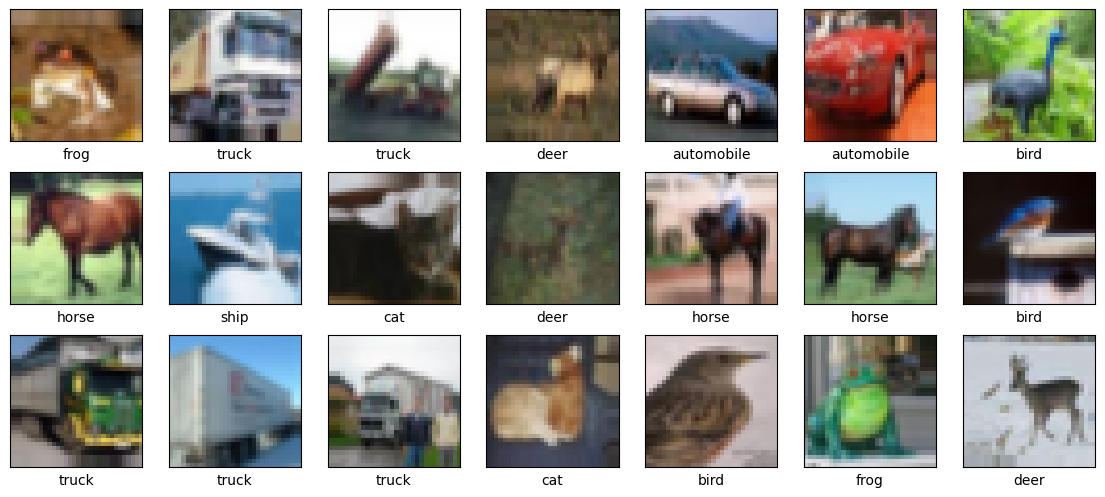

In [ ]:
width_shift = 3/32
height_shift = 3/32
flip = True

datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
    )
datagen.fit(x_train)

it = datagen.flow(x_train, y_train, shuffle=False)
batch_images, batch_labels = next(it)
visualize_data(batch_images, batch_labels, class_names)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test))
score = model.evaluate(x_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 110s 54ms/step - loss: 0.6162 - accuracy: 0.7935 - val_loss: 2.1638 - val_accuracy: 0.5709
Epoch 2/10
1563/1563 [==============================] - 85s 55ms/step - loss: 0.5592 - accuracy: 0.8083 - val_loss: 0.9585 - val_accuracy: 0.7021
Epoch 3/10
1563/1563 [==============================] - 83s 53ms/step - loss: 0.6558 - accuracy: 0.7765 - val_loss: 0.9341 - val_accuracy: 0.6994
Epoch 4/10
1563/1563 [==============================] - 83s 53ms/step - loss: 0.5076 - accuracy: 0.8247 - val_loss: 1.1508 - val_accuracy: 0.6433
Epoch 5/10
1563/1563 [==============================] - 84s 54ms/step - loss: 0.4536 - accuracy: 0.8451 - val_loss: 1.0582 - val_accuracy: 0.6654
Epoch 6/10
1563/1563 [==============================] - 85s 54ms/step - loss: 0.6239 - accuracy: 0.7917 - val_loss: 1.4433 - val_accuracy: 0.6084
Epoch 7/10
1563/1563 [==============================] - 83s 53ms/step - loss: 0.4797 - accuracy: 0.8357 - val_loss: 1.0037 

# Task

## Task 1: Build ResNet-50 with `ResidualUnit50`
You need to fill in the blank in `#FIXIT`
- Build your `ResidualUnit50` class for ResNet-50
- Build your model with `ResidualUnit50`

Remind: **The number of class in CIFAR100 is 100.** Input shape is the same as CIFAR10

In [4]:
class ResidualUnit50(keras.layers.Layer): # ResNet-50
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation) # relu activation inthis example
    self.main_layers = [
        keras.layers.Conv2D(filters//4, 1, strides=strides, padding="same", use_bias=False),
        keras.layers.BatchNormalization(),
        self.activation,
        keras.layers.Conv2D(filters//4, 3, strides=1, padding="same", use_bias=False),
        keras.layers.BatchNormalization(),
        self.activation,
        keras.layers.Conv2D(filters, 1, strides=1, padding="same", use_bias=False),
        keras.layers.BatchNormalization()
      ]

    self.skip_layers = [] # to make skip connection
    if strides > 1:
      self.skip_layers = [
        keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
        keras.layers.BatchNormalization()
        ]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
      skip_Z = inputs
      for layer in self.skip_layers: # adding skip_layers
        skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[32, 32, 3], padding="same", use_bias=False)) ## Answer Here change None
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 0
filter_list = [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512] ## Answer Here
for filters in filter_list:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit50(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation="softmax"))

## Task 2: Training ResNet-50 for CIFAR100

Hint: The image shape of CIFAR100 is the same as CIFAR 10, but it has 10 categories.

In [6]:
# Loading CIFAR100 here
class_names = [
    "beaver", "dolphin", "otter", "seal", "whale",
    "aquarium fish", "flatfish", "ray", "shark", "trout",
    "orchids", "poppies", "roses", "sunflowers", "tulips",
    "bottles", "bowls", "cans", "cups", "plates",
    "apples", "mushrooms", "oranges", "pears", "sweet peppers",
    "clock", "computer keyboard", "lamp", "telephone", "television",
    "bed", "chair", "couch", "table", "wardrobe",
    "bee", "beetle", "butterfly", "caterpillar", "cockroach",
    "bear", "leopard", "lion", "tiger", "wolf",
    "bridge", "castle", "house", "road", "skyscraper",
    "cloud", "forest", "mountain", "plain", "sea",
    "camel", "cattle", "chimpanzee", "elephant", "kangaroo",
    "fox", "porcupine", "possum", "raccoon", "skunk",
    "crab", "lobster", "snail", "spider", "worm",
    "baby", "boy", "girl", "man", "woman",
    "crocodile", "dinosaur", "lizard", "snake", "turtle",
    "hamster", "mouse", "rabbit", "shrew", "squirrel",
    "maple", "oak", "palm", "pine", "willow",
    "bicycle", "bus", "motorcycle", "pickup truck", "train",
    "lawn-mower", "rocket", "streetcar", "tank", "tractor"
]

num_classes = len(class_names)

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# You can add augmentation or data normalization.
x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=3/32,
    height_shift_range=3/32,
    )
datagen.fit(x_train)

169001437/169001437 [==============================] - 13s 0us/step


In [7]:
model.compile(loss="categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test))
score = model.evaluate(x_test, y_test)
x_new = x_test[:10] # pretend we have new images
y_pred = model.predict(x_new)

Epoch 1/10
1563/1563 [==============================] - 135s 52ms/step - loss: 4.5177 - accuracy: 0.0405 - val_loss: 4.2121 - val_accuracy: 0.0686
Epoch 2/10
1563/1563 [==============================] - 78s 50ms/step - loss: 4.0689 - accuracy: 0.0821 - val_loss: 4.4442 - val_accuracy: 0.0950
Epoch 3/10
1563/1563 [==============================] - 78s 50ms/step - loss: 3.8484 - accuracy: 0.1117 - val_loss: 3.6615 - val_accuracy: 0.1366
Epoch 4/10
1563/1563 [==============================] - 77s 49ms/step - loss: 3.6704 - accuracy: 0.1387 - val_loss: 3.7809 - val_accuracy: 0.1390
Epoch 5/10
1563/1563 [==============================] - 78s 50ms/step - loss: 3.5365 - accuracy: 0.1593 - val_loss: 3.5258 - val_accuracy: 0.1636
Epoch 6/10
1563/1563 [==============================] - 77s 49ms/step - loss: 3.4372 - accuracy: 0.1766 - val_loss: 3.4573 - val_accuracy: 0.1905
Epoch 7/10
1563/1563 [==============================] - 76s 48ms/step - loss: 3.3544 - accuracy: 0.1909 - val_loss: 3.8072 

## Task 3
Test your trained ResNet-50 model on test dataset and show that quantitative (accuracy, F1 score etc.) and qualitative(visualize test result) analysis on it

In [8]:
print(f'test accuracy: {score[0]}')
print(f'loss: {score[1]}')

test accuracy: 3.247187376022339
loss: 0.2273000031709671


`test accuracy: 0.2157 and
loss: 4.1876`

In [9]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
print(f'Weighted F1 Score: {f1}')

313/313 [==============================] - 3s 9ms/step
Weighted F1 Score: 0.2127440502056585


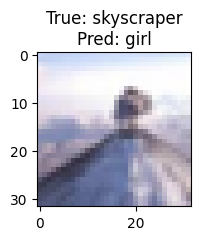

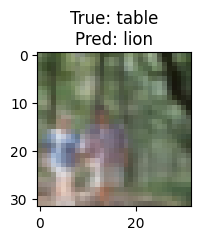

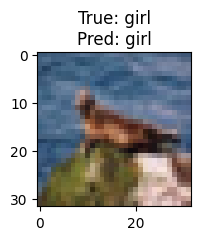

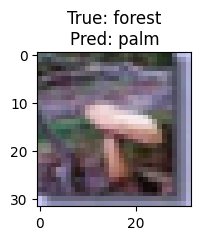

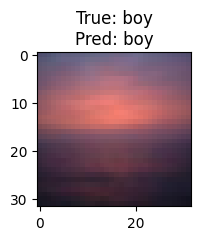

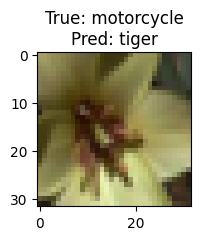

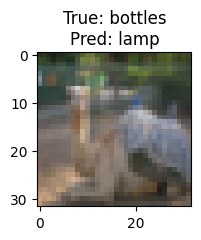

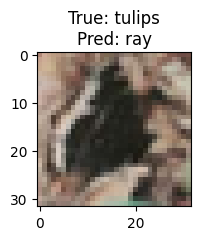

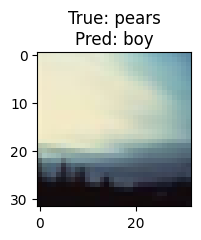

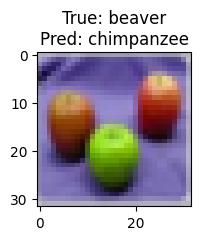

In [10]:
for i in range(10):
    plt.figure(figsize=(2,2))
    plt.imshow(x_test[i])
    true_class = class_names[y_test_labels[i]]
    pred_class = class_names[y_pred_labels[i]]
    plt.title(f'True: {true_class}\nPred: {pred_class}')
    plt.show()